<font size="5">**[Object Detection](https://en.wikipedia.org/wiki/Object_detection) con YOLO**.<br>

> (c) 2025 Antonio Piemontese

# Un sistema di video-sorveglianza


Ecco come costruire **un sistema di videosorveglianza** intelligente e personalizzato per la casa o per il condominio.<br>
Il notebook mostra come installare gratuitamente un sistema di videosorveglianza capace di identificare e contare oggetti e persone in tempo reale, utilizzando solo una webcam e un computer. Nessun costo aggiuntivo per hardware complesso o software costosi.<br>
Basta qualche passo, Python e YOLO11 Ultralitycs per trasformare immediatamente la webcam in una sofisticata telecamera di sorveglianza professionale con riconoscimento degli oggetti.

**Cosa si può fare con questo sistema di videosorveglianza?**<br>
Le applicazioni sono moltissime:
- sorveglianza esterna e interna: ideale per casa, condominio o attività commerciale.
- rilevamento intelligente: ricevi notifiche immediate se delle persone o animali entrano nell’area sorvegliata.
- automazioni avanzate: integra facilmente l’invio automatico di notifiche email o chat 

**Requisiti**:
- una webcam collegata al computer
- Python installato
- la libreria PyTorch per gestire il deep learning sul processore CPU
- il software YOLO11 di Ultralytics, l’ultimo standard per il riconoscimento degli oggetti con intelligenza artificiale.

---
Il notebook è  configurato in modo da funzionare in Jupyter Notebook oppure in Google Colab. L'elaborazione di grandi video è accelerata dalla disponibilità di una GPU.

---

Come prima cosa, quindi, **rileviamo l'ambiente di esecuzione del notebook** (Jupyter oppure Google Colab: la cella imposta una variabile booleana `IN_COLAB` che sarà testata da alcune celle del notebook (in particolare quelle di visualizzazione di immagini) per personalizzarne il comportamento a seconda dell'ambiente di esecuzione dell'ambiente rilevato.

In [1]:
# impostazione del TOGGLE BINARIO:
try:
    import google.colab                      # package disponibile SOLO in Google Colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print("Siamo in Colab:", IN_COLAB)


# IMPORT dei package necessari per la VISUALIZZAZIONE delle IMMAGINI (necessari sia in JN che in Colab):
from IPython.display import Image, display   # import dei package di incorporamento e visualizzazione immagine (una tantum)
                                             # Image e display sono entrambi necessari a Jupyter Notebook
                                             # Google Colab utilizza solo Image
import os                                    # necessario a Google Colab per vedere da una cella codice
                                             # i contenuti del 'content'

Siamo in Colab: False


Le immagini utilizzate in questo notebook, da caricare nella memoria di sessione, sono:
- `modelli_YOLOv8.png`
- `modelli_YOLOv8_costi.png`

# Introduzione

Usiamo `YOLO` v8 (di Ultralytics). Vedi la [voce Wikipedia su YOLO](https://en.wikipedia.org/wiki/You_Only_Look_Once).<br>
Vedi il [sito di Ultralytics](https://www.ultralytics.com/) e la [pagina di Ultralytics sulla *object detection*](https://docs.ultralytics.com/tasks/detect/).
YOLO è un **approccio**, **una tecnologia**; Ultralytics è una **software house** che ha implementato lo standard YOLO (che evolve di continuo: v8 del 2023, v9 del 2024).

YOLO (You Only Look Once) è una famiglia di modelli di **deep learning (reti neurali profonde) per object detection** (in particolare [reti CNN](https://it.wikipedia.org/wiki/Rete_neurale_convoluzionale)) **in tempo reale**, e nel corso degli anni si è evoluta attraverso molte versioni, ciascuna con **tecnologie diverse**. Riassumiamo le **tecnologie chiave** usate in generale, poi focalizziamoci  sulle versioni più recenti (come YOLOv5–**v8** e YOLO-NAS).

---

In generale, YOLO usa:

1. **Reti Neurali Convoluzionali (CNN)**

È la base di tutti i modelli YOLO. Le CNN sono ideali per analizzare immagini (e quindi anche video) grazie alla loro capacità di estrarre automaticamente feature spaziali.

2. **Single-Shot Detection**

YOLO fa **una sola previsione (*prediction*) per immagine** ("you only look once"), dividendo l'immagine in griglie e predicendo, per ogni cella, le **bounding box**, le **classi** e la **confidenza** della classificazione.

3. **Anchor Boxes**

Usate per migliorare la predizione di oggetti con proporzioni diverse (es. un autobus vs un semaforo).

---

**Tecnologie specifiche per versione**:

YOLOv1–v3 (Darknet)

* Scritto in C e CUDA (framework chiamato **Darknet**)
* Usa CNN standard (es. Darknet-19, Darknet-53)
* Più veloce, meno accurato rispetto a modelli moderni

YOLOv4 (AlexeyAB fork)

* Aggiunge tecniche di **training bag of freebies/tricks**
* Include **Mish activation**, **CSPNet**, **Squeeze-and-Excitation**

YOLOv5 (Ultralytics, in PyTorch) - **la svolta**

* Codice 100% in **Python + PyTorch** (la libreria di deep learning più diffusa, completamente open-source, realizzata da Meta)
* Modularità, facilità d’uso, supporto a GPU/CPU
* Augmentazioni: Mosaic, MixUp
* Varianti da YOLOv5s (small) a YOLOv5x (extra large)

YOLOv6 / v7 / v8

* YOLOv6: orientato alla produzione, TensorRT-friendly
* YOLOv7: supporto per **task multipli** (detection, pose, segmentation)
* **YOLOv8 (Ultralytics)**: riscrittura più pulita, supporta anche:

  * Object Detection
  * Semantic Segmentation
  * Instance Segmentation
  * Pose Estimation
  * Classificazione

È **quella che useremo**: il modello infatti è in `.pt` e usi `YOLO(...)`.

**YOLOv9** è stato rilasciato nel 2024 e porta importanti miglioramenti.

YOLO-NAS (Neural Architecture Search)

* Proposto da **Deci AI**
* Basato su **NAS**: la rete è "ottimizzata automaticamente"
* Più accurato e veloce rispetto alle versioni precedenti, con attenzione alle prestazioni su dispositivi edge

---

Backend tecnologici recenti

| Tecnologia          | Dettagli                                  |
| ------------------- | ----------------------------------------- |
| **PyTorch**         | usato da YOLOv5, YOLOv8 (Ultralytics)     |
| **ONNX / TensorRT** | esportazione per inferenza ottimizzata    |
| **OpenCV**          | usato per video processing e I/O immagini |
| **TorchScript**     | usato per ottimizzare i modelli PyTorch   |
| **CUDA / cuDNN**    | se usi GPU NVIDIA                         |

---

YOLO è veloce perché…

* Tutta la detection avviene **in una sola passata** (vs modelli two-stage come Faster R-CNN)
* È ottimizzato per inferenza real-time, anche su hardware non super potente

NB. Nel mondo del Deep Learning, per "inferenza" si intende l'utilizzo di una rete pre-allenata.

---



# Installazioni per Jupyter Notebook
Da un prompt anaconda, attivo sull'ambiente virtuale di vostra scelta (comunque lo stesso del kernel di Jupyter Notebook).

Per sicurezza, come prima cosa, disinstalliamo PyTorch, la libreria di Deep Learning open-source di Meta. Vedi [qui](https://pytorch.org/).

PyTorch è il porting su Python della libreria Torch. PyTorch ha oggi più successo di Torch (l'allievo ha superato il maestro). Gli sviluppatori di Meta, in omaggio a Torch, hanno chiamato la libreria PyTorch `Torch`. `PyTorch` è solo il termine conevenzionale di riferimento, ma **la installazione e la import la si fa di torch**.

In [2]:
!pip uninstall torch torchvision torchaudio

^C


Installiamo `PyTorch` **per CPU**.

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

L'output atteso (corretto) è il seguente:<br>
`Successfully installed torch-2.7.1+cpu torchaudio-2.7.1+cpu torchvision-0.22.1+cpu`<br>
Ha installato l'ultima versione dei 3 package **per CPU**, come chiesto da noi.

La descrizione del package [PyTorch](https://pypi.org/project/pytorch/) come sempre è ricavabile consultanno l'indice ufficiale di tutti i package python: [**PyPI**](https://pypi.org/).

Installazione di YOLO (nella implementazione della software house **ultralytics**):

In [ ]:
!pip install -U ultralytics

Invece, il seguente comando:

```python
pip install -U ultralytics
```
aggiorna all'ultima versione disponibile, anche se ultralytics è già installato. Cioè:<br>
- `pip install ultralytics` → installa solo se non è già presente
- `pip install -U ultralytics` → forza l’aggiornamento all’ultima versione.

# Installazioni per Google Colab
*PyTorch* è già installato nella sessione di Google Colab.

Esistono differenti versioni di PyTorch, a seconda del tipo di run-time (CPU, GPU, TPU, ecc), Google Colab rende disponibile la versione di PyTorch adatta al run-time che abbiamo scelto.

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.8.0+cpu
False


Se il runtime scelto è di tipo 'GPU', `torch.cuda` è disponibile e la print dirà "True".

Per le TPU su Colab, per PyTorch si deve usare la libreria `torch_xla`, es:

```python
import torch_xla
import torch_xla.core.xla_model as xm
device = xm.xla_device()
```

Ma attenzione: è una configurazione un po’ più avanzata e non tutte le librerie sono compatibili. In generale, **se si sta usando PyTorch standard, meglio usare il runtime GPU**.



La libreria `Ultralytics` deve invece esere installata , come fatto in Jupyter Notebook. Occorrono circa **3 minuti**.<br>
Alcune dipendenze risultano già presenti, ma l'installazione è indispensabile altrimenti la successiva *import* della libreria non funzionerà.

In [ ]:
!pip install -U ultralytics

# YOLO vs Ultralytics

---
La confusione tra **YOLO** e **Ultralytics** è comune, ma i due termini indicano **cose diverse**.

---

In breve:

| Termine         | Cos'è                                                                               |
| --------------- | ----------------------------------------------------------------------------------- |
| **YOLO**        | Una *famiglia di modelli* per object detection                                      |
| **Ultralytics** | Un’**azienda** + una **libreria Python** open source che implementa YOLO in PyTorch |

---

Approfondiamo:

**YOLO (You Only Look Once)**

* È un **approccio di object detection one-shot**: elabora l’intera immagine in una sola passata della rete.
* Nato nel 2015 da **Joseph Redmon**, con YOLOv1.
* Si è evoluto nel tempo in:

  * YOLOv1 → YOLOv2 → YOLOv3 (basati su **Darknet**, framework in C/CUDA)
  * Fork come YOLOv4 (Alexey Bochkovskiy), YOLOv5, YOLOv6, YOLOv7, YOLOv8, YOLO-NAS...
* YOLO è oggi più un **"paradigma" di detection veloce e realtime** che un singolo modello. E' uno standard?!

---

**Ultralytics**

* È una **software house** che:

  * Ha sviluppato **YOLOv5** (2020) e poi **YOLOv8** (2023)
  * Ha riscritto YOLO interamente in **PyTorch**
  * Ha creato la libreria `ultralytics` che semplifica tutto: training, inferenza (l'utilizzo), export (dei risultati).

* Il comando `from ultralytics import YOLO` fa parte proprio di questa libreria.

> **YOLOv8** è la penultima versione del modello YOLO sviluppata da Ultralytics (rilasciata a gennaio 2023).<br>
> La libreria ultralytics che contiene YOLOv8 ha invece una numerazione delle versioni software separata, ed è arrivata alla versione **v11.x**.
Vedi [questa pagina](https://github.com/ultralytics/assets/releases) di Ultralytics per chiarimenti.

---


In [3]:
from ultralytics import YOLO   # 2-3 secondi di esecuzione

# I modelli di YOLO

YOLOv8 mette a disposizione 5 modelli di riconoscimento oggetti (gratuiti), qui riferiti alla v11 di Ultralytics:
- `yolo11n`: la versione **nano**, quella meno precisa e che richiede meno risorse
- `yolo11s`: la versione **small**
- `yolo11m`: la versione **media**
- `yolo11l`: la versione **large**
- `yolo11x`: la versione **extra-large**



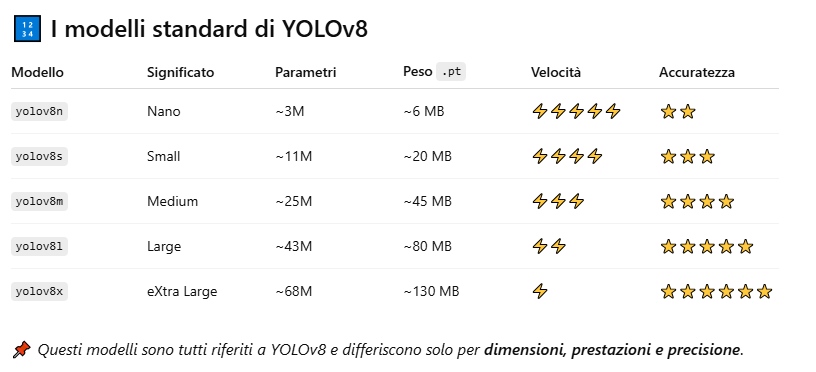

In [4]:
Image('modelli_YOLOv8.png') if IN_COLAB else display(Image(filename='modelli_YOLOv8.png'))

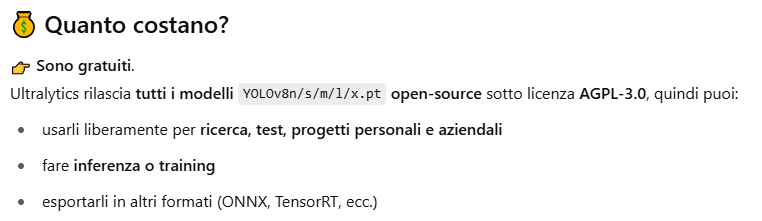

In [5]:
Image('modelli_YOLOv8_costi.png') if IN_COLAB else display(Image(filename='modelli_YOLOv8_costi.png'))

# Il webhook

In [6]:
URL_WEBHOOK = "https://hooks.zapier.com/hooks/catch/23724713/u3l6nas/"

# Yolo v26

[Qui](https://www.tiktok.com/@brainlink_project/video/7554513155913944342?_r=1&_t=ZN-90HQ0cLFNNG) un video di [***brainlink***](https://www.youtube.com/channel/UCyKvp4laNQfYUql3zmiMMhg/about) - una ottima academy sulla AI e ML - sull'**ultima versione di Yolo, la v26**, uscita ad inizio ottobre 2025.

# Il nostro modello (per questo notebook)

Scarichiamo il modello YOLO (l'ultimo) con la funzione `YOLO` prima importata.

In [7]:
model = YOLO("yolo11m.pt")    # il modello YOLO da usare per il riconoscimento degli oggetti.
                              # lo scarica

> `.pt` → è un modello PyTorch salvato, compatibile con ultralytics.

Nell'oggetto `model` abbiamo il modello **PREALLENATO ISTANZIATO**.

Vediamo la **classe** dell'oggetto e poi **l'architettura** del modello:

In [8]:
type(model)

ultralytics.models.yolo.model.YOLO

In [9]:
model.model    # la sequenza dei layer della CNN; per noi in questo corso può rimanere non comprensibile.

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
   

Sintesi dei layer:

In [10]:
for i, layer in enumerate(model.model.model):
    print(f"{i}: {layer.__class__.__name__}")

0: Conv
1: Conv
2: C3k2
3: Conv
4: C3k2
5: Conv
6: C3k2
7: Conv
8: C3k2
9: SPPF
10: C2PSA
11: Upsample
12: Concat
13: C3k2
14: Upsample
15: Concat
16: C3k2
17: Conv
18: Concat
19: C3k2
20: Conv
21: Concat
22: C3k2
23: Detect


Vediamo ora il **numero totale dei parametri**:

In [11]:
total_params = sum(p.numel() for p in model.model.parameters())
trainable_params = sum(p.numel() for p in model.model.parameters() if p.requires_grad)

print(f"Totale parametri: {total_params:,}")
print(f"Parametri trainabili: {trainable_params:,}")


Totale parametri: 20,114,688
Parametri trainabili: 0


I parametri trainabili sono 0 significa che il modello, allenato con PyTorch, è stato poi bloccato in modalità "inference only", cioè tutte le `requires_grad` sono state impostate a False. In altre parole, **questo modello può essere usato ma non riallenato**.

Questo è perfettamente lecito se il modello viene:
- caricato solo per inferenza (non per addestramento o fine-tuning),
- esportato da un training precedente con `requires_grad=False`,
- oppure se è stato congelato volutamente per risparmiare risorse.

---
L'elenco (ed il numero totale) delle **classi che il modello è in grado di riconoscere**.
80 non è affatto male.
C'è comunque sempre un trade-off: maggiore è il numero di classi riconoscibili dal modello, maggiore è anche la complessità computazionale.

---

In [12]:
print(model.names)
print(f"Numero classi: {len(model.names)}")

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

Il file `yolo11m.pt` è un modello YOLOv8 **pre-addestrato sul dataset COCO** (Common Objects in Context).

Cosa significa? **Rileva 80 classi**, che sono esattamente le classi ufficiali del dataset COCO.

Questo modello non è personalizzato (cioè non è stato fine-tuned su un nostro dataset).

È una copia rinominata di **yolov8m.pt** o **yolov8x.pt** (a seconda della dimensione).

Qualche dettaglio extra:
- Il dataset COCO è uno **standard per object detection**, contiene oggetti comuni: persone, animali, veicoli, oggetti domestici...
- È il riferimento principale per il confronto tra modelli YOLO, SSD, Faster R-CNN, ecc.
- I modelli preaddestrati su COCO sono molto efficaci out-of-the-box per **scene urbane, case, interni, ecc**. E quindi ideali per la video-sorveglianza, che è il nostro obiettivo.


# L'allenamento di Yolo
Un'idea intuitiva è data in [questo breve video](https://www.tiktok.com/@brainlink_project/video/7555861765465132310?_r=1&_t=ZN-90IxdCw2wzO) di *brainlink*.<br>
Concetti: 
- funzione di perdita *J* (*loss function*), da minimizzare
- *intersection over union*
- le immagini di training sono corredate del "vero" *bounding box* (la *ground truth*) 

# Il caricamento del video (per Google Colab)

Per prima cosa dobbiamo caricare nella **memoria di sessione** il video da rilevare.<br>

*FARE l'upload del video nella memoria di sessione*

Verifichiamone la presenza:

In [13]:
import os                        # il package 'os' (che sta per operating system) fornisce una serie di funzioni per interagire con il sottostante sistema operativo
                                 # il s.o. di una macchina virtuale di Google Colab è Linux
print(os.listdir('/content'))


FileNotFoundError: [WinError 3] Impossibile trovare il percorso specificato: '/content'

YOLO funziona meglio con video registrati **in formato orizzontale**. Se il video in input è stato registrato <u>in formato verticale (come il file `video_strada_2.mp4`)</u> lo possiamo **centrare** in formato orizzontale con "padding" nero intorno, con la libreria `ffmpeg`.

La seguente cella mantiene il contenuto verticale intatto, ma lo centra in un video orizzontale.<br>
Cosa fa esattamente?
- `scale=-1:1080` → mantiene l’altezza a 1080, adatta la larghezza proporzionalmente
- pad=1920:1080:(ow-iw)/2:(oh-ih)/2 → incornicia il video con bande nere per portarlo a 1920×1080 centrato

Il parametro `-i` indica il file di input, il parametro `-vf` indica il tipo di "video filter" applicato (es. rotazioni, ridimensionamenti, sfocature, ecc.).

Tempo di esecuzione: circa 2'.








In [17]:
!ffmpeg -i video_strada.mp4 -vf "scale=-1:1080,pad=1920:1080:(ow-iw)/2:(oh-ih)/2" video_strada_out.mp4

ffmpeg version 7.0.1-essentials_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.2.0 (Rev5, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-dxva2 --enable-d3d11va --enable-d3d12va --enable-ffnvcodec --enable-libvpl --enable-nvdec --enable-nvenc --enable-vaapi --enable-libgme --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame -

Eseguiamolo (20 secondi di caricamento):

In [14]:
if IN_COLAB:
    from IPython.display import Video, display
    display(Video("/content/video_strada_2_landscape.mp4", embed=True, width=640))

Il rendering precedente funziona con Chrome (browser e IDE dello **stesso ecosistema Google!**), ha problemi con Firefox.

Possiamo preliminarmente fare **alcune analisi del nostro video <u>in input</u>**.

Per sapere il **numero di frame** del nostro video ed avere anche **altre informazioni** sul video stesso si usa il package `cv2`, il modulo Python di OpenCV (Open Source Computer Vision Library), e il metodo `VideoCapture`:

In [15]:
import cv2

cap = cv2.VideoCapture("video_strada_out.mp4")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

print(f"Numero totale di frame: {total_frames}")


Numero totale di frame: 954


Per avere altre informazioni:

In [16]:
import cv2

# Apri il video
cap = cv2.VideoCapture("video_strada_out.mp4")

# Estrai informazioni
fps = cap.get(cv2.CAP_PROP_FPS)  # frame per secondo
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # numero totale di frame
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # larghezza frame
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # altezza frame
duration = frame_count / fps  # durata in secondi

# Mostra le info
print(f"Risoluzione: {width}x{height}")
print(f"FPS: {fps}")
print(f"Numero totale di frame: {frame_count}")
print(f"Durata del video: {duration:.2f} secondi")

cap.release()


Risoluzione: 1920x1080
FPS: 30.0
Numero totale di frame: 954
Durata del video: 31.80 secondi


In [17]:
954/31.00 # frame per second

30.774193548387096

# Il rilevamento degli oggetti

**<u>E ora finalmente facciamo il rilevamento degli oggetti</u>**, tramite il metodo `model.predict` di *Ultralytics*.

L'elaborazione del file `video_strada_2.mp4` richiede:
- **circa 3'30"** sulla CPU 4Ghz, 16GB RAM del mio desktop
- **circa 4'20"** sulla T4-GPU con high-ram di Colab
- **circa 6'20"** sulla CPU di Colab

NB. High RAM deselezionato **peggiora** molto questi tempi.

Vedi più avanti per un commento tecnico a questi tempi di esecuzione.

Il rilevamento oggetti tecnicamente parlando è una **previsione** di inboxing/classificazione di ogni cella della griglia, per ogni dataframe. E' una sola (YOLO v8 è one-shot). Da qui il nome del metodo di *Ultralytics* `(model.predict)`.

---
> Nella AI questa si chiama **inferenza** (del modello allenato, cioè del **suo uso per prevedere/classificare/generare**).

---

I parametri della `model.predict`:
- `source`:
    * `source=0` per la webcam principale - in genere 0,1, oppure 2 (provare)
    * `source="path/to/image.jpg"` per un’immagine
    * `source="path/to/video.mp4"` per un video
    * `source="rtsp://..."` per uno stream IP
- `device='cpu'`:
    * usa la CPU per l’elaborazione.
    * se si ha una GPU e si ha installato PyTorch con supporto CUDA, si può impostare `device='cuda'`.
- `imgsz=640`:
    * imposta la dimensione dei frame a 640×640 pixel.
    * YOLOv8 lavora meglio se le immagini sono quadrate e di dimensioni standard (320, 640, 1280…).
    * maggiore è il valore, più dettagli cattura (ma serve più potenza hardware).<br>
    NB. il parametro imgsz` **si riferisce all’input**, ovvero alla dimensione con cui YOLOv8 ridimensiona ogni frame del video prima di passarlo alla rete neurale per il rilevamento oggetti.<br>
    Cosa fa esattamente imgsz=640?<br>
      - Ogni frame del video viene ridimensionato (resized) a una risoluzione di 640×640 pixel.
      - Questo è il formato di input atteso dal modello per lavorare in modo ottimale.
      - Non cambia la risoluzione originale del video, né influenza direttamente la risoluzione del video in output, che può rimanere uguale all’originale (a seconda del backend di salvataggio usato da Ultralytics).



- `conf=0.1`:
    * imposta la confidence threshold a 0.1.
    * YOLO rileva oggetti solo se la probabilità della classe è superiore a questo valore.
    * **di solito si imposta tra 0.25 e 0.5**, ma qui l'abbiamo messa bassa per “vedere tutto quello che il modello riesce a pescare” (le sue potenzialità).
    * si è visto sperimentalmente che, con questa confidenza, YOLOv8 fa comunque pochi errori (mis-classificazioni)
- `show=True`:
    * mostra le immagini o i frame annotati in una finestra pop-up (usando `cv2.imshow`) in tempo reale; non funziona in Jupyter Notebook o Google Colab, **solo in ambienti standalone** (come Spyder, IDLE o script Python lanciati da terminale).
- `stream=True`:
    * se True, processa i frame in **streaming**; è utile nei notebook per evitare che vengano salvati tutti i frame nella variabile `results` (che occuperebbe tanta RAM).
    * cioè, invece di restituire tutti i risultati in una lista in memoria (`results`), YOLOv8 ti restituisce un generatore, cioè un oggetto che produce i risultati uno alla volta, frame per frame.<br>
    Questo:
      - riduce il consumo di RAM
      - è perfetto per video lunghi
      - funziona benissimo anche con GPU


- `save=True`:
    * salva il video di output (annotato con bounding box, etichette di classe, confidenze) nella directory `runs/detect/predictN` di default. Il nome del file sarà simile al <nome-video.**mp4**> ma modificato come formato (es: <nome-video.**avi**>)

La `model.predict` PUO' essere assegnata ad una variabile di risultato, come detto prima e come fatto nella cella successiva (`results`):

In [ ]:
results = model.predict(
    # source=0,
    source='video_strada_out.mp4',
    device='cpu',   # oppure 'gpu'
    imgsz=640,
    conf=0.1,
    # show=True,
    # stream = True,   # def. False
    save=True
)



WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/954) C:\Users\Utente\Desktop\salvataggi\SALVATAGGIO DATI\Documents\Seminari\Data Science (corsi)\Corso Reti Neurali\Computer Vision\video_strada_out.mp4: 384x640 2 cars, 166.1ms
video 1/1 (frame 2/954) C:\Users\Utente\Desktop\salvataggi\SALVATAGGIO DATI\Documents\Seminari\Data Science (corsi)\Corso Reti Neurali\Computer Vision\video_strada_out.mp4: 384x640 2 persons, 2 cars, 140.4ms
video 1/1 (frame 3/954) C:\Users\Utente\Desktop\salvat

Il codice di questa cella analizza il video frame per frame, rileva oggetti oppure no ("no detections") nei vari frame, salva il video **annotato (bounding box, etichette, confidenza**) nella sotto directory `runs/predict/predictN/`.

`model.predict()` **termina automaticamente** quando ha processato tutti i frame del video.

In questo caso:
- il video ha 965 frame (lo si vede dal log)
- YOLO elabora un frame alla volta
- alla fine, salva il video elaborato nella cartella `runs/predict/predictX/`

**Quanto ci mette?** Dipende da:
- CPU (più lenta rispetto a una GPU)
- Lunghezza del video (in secondi / numero di frame)
- Risoluzione dei frame (imgsz=640)
- Numero di oggetti rilevati per frame

Con CPU su un video normale (1 minuto a 30 fps = ~1800 frame), può impiegare anche diversi minuti (es. 2–10 minuti).

**Come sapere quando ha finito?**<br>
Nel log c'è una riga senza più aggiornamento dei frame.<br>
L’ultima riga dirà qualcosa tipo:<br>
*Results saved to runs\predict\predict3*<br>
Oppure:<br>
*video 1/1 (frame 954/954) ... DONE (123.4ms)*

---
NB. A volte la GPU di Colab (anche la "High-RAM") può andare **più lenta della CPU locale del proprio PC!**

🚦 MOTIVI PRINCIPALI
1. Overhead del caricamento su GPU<br>
Il video (.mp4) deve essere:
  - letto da disco,
  - decodificato in frame,
  -convertito in tensori,
  - spostato nella memoria della GPU (cuda).

👉 Tutto questo richiede tempo e non è accelerato dalla GPU, quindi su video corti o piccoli il vantaggio della GPU non si vede (anzi: può peggiorare le performance).

---

# L'interpretazione dei risultati
Il metodo `model.predict` fornisce tre output:
- il log (in tempo reale)
- il video annotato
- i `results` su disco.

**Ma vediamo ora i contenuti della variabile `results`**:<br> è una lista di oggetti `ultralytics.engine.results.Results`, **uno per ogni frame** (o immagine, se l'input è un'immagine).

Ogni oggetto contiene:
- `.boxes` → le box previste
- `.probs` → le probabilità (se classifica)
- `.keypoints`, `.masks` → se si sono abilitate segmentazione o pose
-`.plot()` → disegna le box su un’immagine
- `.save()` → salva il frame annotato
- `.orig_img` → immagine originale
- `.names` → nomi delle classi

In [ ]:
type(results)   # una LISTA!

In [ ]:
len(results)    # un elemento della lista per ogni frame

In [ ]:
results[0]      # il primo frame (ottenuto tramite il subsetting di lista)
                # molte info sono nel primo campo 'boxes': un oggetto ultralytics.engine.results.Results

In [ ]:
type(results[0])

Estraiamo da `results` le classi individuate nel primo frame:

In [ ]:
results[1].boxes.cls

2 è la classe *cars*, 0 è la classe *person*, 3 è la classe *motorcycle* - vedi log precedente.

Ora estraiamo da `results` le probabilità (**confidence**) delle classi individuate (nel primo frame):



In [ ]:
results[1].boxes.conf

Nessuna classe rilevata ha confidenza inferiore al valore 0.10, che infatti avevamo impostato nella `model.predict` come valore soglia limite.

Esempio strutturato: stampare le classi rilevate per i primi 5 frame.

In [ ]:
for r in results[:5]:
    print([r.names[int(cls)] for cls in r.boxes.cls])

Il video in oggetto è affollato da macchine parcheggiate.

Esempio strutturato: stampare le probabilità  delle classi rilevate per i primi 5 frame:

In [ ]:
for i, r in enumerate(results[:5]):
    print(f"\n Frame {i+1}")
    boxes = r.boxes
    for j in range(len(boxes)):
        cls_id = int(boxes.cls[j])         # ID classe predetta
        cls_name = r.names[cls_id]         # nome della classe
        conf = float(boxes.conf[j])        # confidenza
        print(f" - {cls_name:15s} conf: {conf:.2f}")


---
> Oltre alla variabile `results` (ed al log), la `model.predict()` di YOLOv8 (*Ultralytics*) restituisce in output il file `.avi` annotato (**vedi la cartella sottostante (Windows o Linux)**.

> Il file non è in formato `.mp4` per **scelta tecnica predefinita** della libreria, che usa `OpenCV (cv2)` per salvare i video.

> Secondo chatGPT, il formato `.avi` è ottimo per:
- analisi video con modelli ML	- AVI (meno compressione → meno perdita info)
- montaggio video con poco decoding	AVI


> Tuttavia, il formato `.avi` non è <u>sempre</u> ben supportato nei browser. Si deve **convertire** in `.mp4` con la famosa libreria [`ffmpeg`](https://en.wikipedia.org/wiki/FFmpeg) (qualche minuto).

> Attenzione: l'output `.mp4` deve essere salvato anch'esso nella sotto-directory `runs/detect/predict` per non sovrascrivere l'originale!

---

In [ ]:
!ffmpeg -i runs/detect/predict2/video_strada_2_landscape.avi -vcodec libx264 -crf 23 runs/detect/predict2/video_strada_2_landscape.mp4

# L'esecuzione del file

Eseguiamo il file.

In <u>Jupyter Notebook su Windows</u> è sufficiente fare **doppio click** sul file prodotto nella directory `run/detect/predictN`.

In <u>Google Colab su Linux</u> non si può eseguire il video con doppio click, perché non è un ambiente desktop. Però si può visualizzarlo dentro il notebook in questo semplice modo:

In [ ]:
if IN_COLAB:
  from IPython.display import Video
  display(Video("/content/runs/detect/predict2/video_strada_2_landscape.mp4", embed=True, width=640))



Con lo stream:

In [ ]:
results = model.predict(source='video_strada_2.mp4', stream=True)
for r in results:
    print(r.boxes)  # stampa le box del frame corrente


# Script standalone
Ecco una **versione interattiva** del codice precedente pensata per essere eseguita in uno script Python standalone (**non in Jupyter, ma da shell**), in modo che venga mostrato **in tempo reale** il video con i bounding box rilevati da YOLOv8:

```python
from ultralytics import YOLO
model = YOLO("yolo11m.pt")
model.predict(
    source="video_strada.mp4",  
    device='cpu',              
    imgsz=640,
    conf=0.3,                
    show=True,                  
    stream=False,              
    save=False                 
)
```
**Note**:<br>
- `show=True` funziona solo fuori da Jupyter (es. lanciando da terminale: *python yolo_video.py*)
- si può usare `source=0` per la webcam live
- se si vuole anche salvare il video annotato, impostare `save=True`
- `stream=False` va bene se il video è corto; se è lungo, si può impostare `stream=True` per evitare uso eccessivo di RAM

---
Il file **script_standalone.py** contiene il codice per la shell mostrato in questa cella; eseguirlo in questo modo:
- attivare un prompt anaconda
- attivare l'ambiente *myenv* (dove questo notebook ha fatto le installazioni dei package)
- posizionarsi nella directory corrente di questo notebook con:<br>
*cd C:/Users/Utente/Desktop/salvataggi/SALVATAGGIO DATI/Documents/Seminari/Data Science (corsi)/Corso Reti Neurali/Computer Vision*
- eseguire `python script_standalone.py`

---

Qui un [utile video](https://docs.ultralytics.com/modes/predict/#introduction) sulla estrazione dei risultati dell'inferenza.

# YOLO vs OpenCV

OpenCV e YOLO sono due pilastri nel mondo della Computer Vision, ma **servono a scopi diversi** (anche se possono essere usati insieme). Vediamo le differenze con vari punti chiave e poi qualche esempio d’uso.

**1. Cos'è OpenCV?**
OpenCV (Open Source Computer Vision Library) è una libreria generalista per la computer vision.

È scritta in C/C++ ma ha binding per Python, Java, ecc.

Serve per elaborazione di immagini e video: **filtri, segmentazione, morphing, motion tracking, ecc**.

Contiene algoritmi tradizionali di visione artificiale (no AI): ad esempio, edge detection, template matching, optical flow, ecc.

Ha anche moduli per machine learning, ma non nasce per le reti neurali.

**Esempi di cosa puoi fare con OpenCV**:

Rilevare un volto con Haar Cascade

Trovare contorni in un’immagine

Applicare filtri, trasformazioni geometriche

Lavorare con videocamere

**Cos'è YOLO?**

YOLO (You Only Look Once) è un **algoritmo di object detection basato su deep learning**, ovvero:

Usa una rete neurale convoluzionale (CNN)

Rileva e **classifica oggetti** in un’immagine o un video in tempo reale (frame per frame)

Ti restituisce bounding box, label, confidenza

Le versioni recenti (YOLOv5, v7, v8, v9) sono super veloci ed efficienti, anche su mobile e CPU.

**Esempi di cosa fa YOLO**:

In un video di traffico: individua auto, persone, semafori, moto

In uno stadio: individua giocatori, palloni, arbitri

In un magazzino: rileva scatole, prodotti, pallet

Inoltre registra gli oggetti rilevati.



---
**Video sorveglianza di giardini, case, stanze, ecc tramite webcam.**<br>
In tempo reale e gratuitamente.<br>
Produzione di statistiche sugli oggetti / persone / animali rilevati.<br>
Alert via email con frame allegato, per valutare se il positivo è vero o falso (l'11 luglio).

---

# Generatori di codice: esercizio

E' possibile avere una barra di avanzamento della `model.predict`?<br>
Chiedere a chatGPT o Claude.

---

# Versione 2: email di warning
Facciamo un miglioramento al nostro sistema di video-sorveglianza.<br>
Quando nel campo visivo della webcam compare una persona il sistema in automatico invia una email con quel frame. E' importante per riconoscere i falsi positivi.<br>


In [ ]:
from ultralytics import YOLO
import requests
import cv2
from datetime import datetime, timedelta

In [ ]:
# Inserire la URL di Zapier
URL_WEBHOOK = "https://hooks.zapier.com/hooks/catch/23724713/u3l6nas/"

In [ ]:
# Carica il modello
modello = YOLO("yolo11m.pt")

In [ ]:
for result in modello.predict(
    source='video_strada_2.mp4',
    device='cpu',
    imgsz=640,
    conf=0.1,
    # stream=True,    # streaming frame-by-frame
    show=True       # mantiene la visualizzazione live
):
    # Classi rilevate nel frame
    id_classi = result.boxes.cls.cpu().numpy().astype(int)
 
    # Se c'è almeno una persona (classe 0)
    if 0 in id_classi:
        ora_corrente = datetime.now()
        # Controlla se è passato abbastanza tempo dall'ultimo invio
        if ultimo_invio is None or ora_corrente - ultimo_invio >= pausa_di_attesa:
            # Prepara il frame annotato
            frame = result.plot()  # numpy array BGR
            success, buffer = cv2.imencode('.jpg', frame)
            if not success:
                continue
 
            # Pre‐formatting del timestamp: HH:mm D/M/YY
            day   = ora_corrente.day
            month = ora_corrente.month
            year2 = ora_corrente.year % 100
            # es. "10:09 23/6/25"
            formatted_timestamp = ora_corrente.strftime("%H:%M ") + f"{day}/{month}/{year2:02}"
 
            # Payload testuale
            data = {
                "event":     "person_detected",
                "count":     int((id_classi == 0).sum()),
                "timestamp": formatted_timestamp
            }
            # File binary
            files = {
                "file": ("frame.jpg", buffer.tobytes(), "image/jpeg")
            }
 
            try:
                requests.post(URL_WEBHOOK, data=data, files=files, timeout=5).raise_for_status()
                print(f"[{formatted_timestamp}] Webhook inviato con frame allegato")
                ultimo_invio = ora_corrente
            except requests.RequestException as errore:
                print("Errore invio webhook:", errore)